# Tutorial

In this tutorial we create a (simplified) synthetic galaxy image from scratch, along with its associated segmentation map, and then run the statmorph code on it.

### Setting up

We import some Python packages first. If you are missing any of these, see the the Installation section of the README.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from astropy.visualization import LogStretch
from astropy.modeling import models
import photutils
import time
import statmorph
%matplotlib inline

For convenience, define functions to normalize and apply logarithmic scaling to our images:

In [2]:
log_stretch = LogStretch(a=10000.0)

def normalize(image):
    m, M = np.min(image), np.max(image)
    return (image-m) / (M-m)

### Creating a model galaxy image

We assume that the image size is 240x240 pixels, and that the "true" light distribution is described by a 2D Sersic profile:

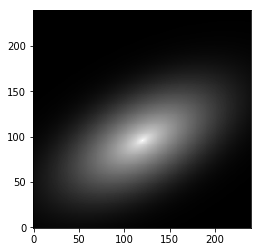

In [3]:
ny, nx = 240, 240
y, x = np.mgrid[0:ny, 0:nx]
sersic_model = models.Sersic2D(amplitude=1, r_eff=20, n=1.5, x_0=0.5*nx, y_0=0.4*ny,
                               ellip=0.5, theta=0.5)
image = sersic_model(x, y)
plt.imshow(log_stretch(normalize(image)), origin='lower', cmap='gray')

### Convolving with a PSF

In practice, every astronomical image is the convolution of a "true" image with a point spread function (PSF), which depends on the optics of the telescope, atmospheric conditions, etc. Here we assume that the PSF is a simple 2D Gaussian distribution:

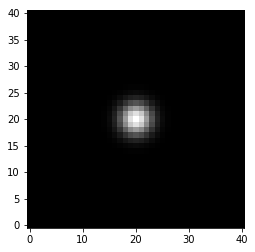

In [4]:
size = 20  # on each side from the center
sigma_psf = 2.0
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)
plt.imshow(psf, origin='lower', cmap='gray')

Now we convolve the image with the PSF.

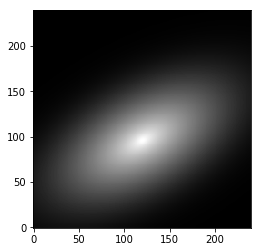

In [5]:
image = ndi.convolve(image, psf)
plt.imshow(log_stretch(normalize(image)), origin='lower', cmap='gray')

### Adding noise

Here we add homogeneous Gaussian noise, assuming that the signal-to-noise ratio (S/N) is 25 at the effective radius (where we defined the Sérsic profile amplitude as 1.0).

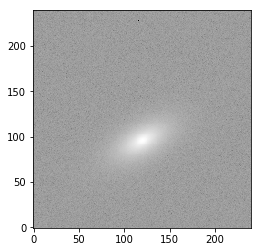

In [6]:
np.random.seed(0)
snp = 25.0
image += (1.0 / snp) * np.random.standard_normal(size=(ny, nx))
plt.imshow(log_stretch(normalize(image)), origin='lower', cmap='gray')

### Gain and weight maps

The code will ask for one of two input arguments: (1) a weight map, which is a 2D array (of the same size as the input image) representing one standard deviation at each pixel value, or (2) the gain, which is a conversion factor that, when multiplied by the science image, gives the number of counts in each pixel. This is then used by statmorph to calculate the weight map internally.

Here we assume, rather arbitrarily, that there is an average of 10 counts/pixel at the effective radius (where we defined the amplitude as 1.0), so that the gain is 10.0.

In [7]:
gain = 100.0

### Creating a segmentation map

Besides the image itself, the only other *required* argument is the segmentation map, which labels the pixels belonging to different sources. It is usually generated by specialized tools such as SExtractor, but here we do it using photutils:

In [8]:
threshold = photutils.detect_threshold(image, snr=1.5)
npixels = 5  # minimum number of connected pixels
segm = photutils.detect_sources(image, threshold, npixels)

Although statmorph is designed to process all the sources labeled by the segmentation map, in this example we only focus on the main (largest) source found in the image.

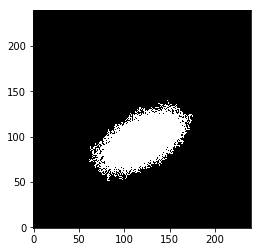

In [9]:
# Keep only the largest segment (label=0 is reserved for the background)
label = np.argmax(segm.areas[1:]) + 1
segmap = segm.data == label
plt.imshow(segmap, origin='lower', cmap='gray')

Regularize a bit the shape of the segmentation map:

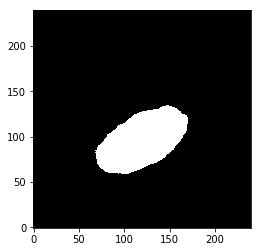

In [10]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
segmap = segmap_float > 0.5
plt.imshow(segmap, origin='lower', cmap='gray')

### Measuring morphology

Now that we have all the required data, we are ready to measure the morphology of the source just created. Although not required, we are including the PSF as a keyword argument. In principle, this results in more correct Sersic profile fits, although it also makes the code run slower, depending on the size of the PSF.

In [11]:
start = time.time()
source_morphs = statmorph.source_morphology(image, segmap, gain=gain, psf=psf)
print('Time: %g s.' % (time.time() - start))

Finished processing source 1.

Time: 2.28254 s.


In general, source_morphs is a list of objects, each corresponding to a labeled source in the image. However, here we only focus on the first labeled source.

In [12]:
morph = source_morphs[0]

Now we print and examine some of the morphological properties just calculated:

In [13]:
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

xc_centroid = 120.43956643381725
yc_centroid = 96.45734791403102
ellipticity_centroid = 0.4897420847113665
elongation_centroid = 1.9597932144459496
orientation_centroid = 0.5044181298325386
xc_asymmetry = 120.14904588046332
yc_asymmetry = 96.09589615948855
ellipticity_asymmetry = 0.48979622225773334
elongation_asymmetry = 1.9600011674260036
orientation_asymmetry = 0.504750510635192
rpetro_circ = 33.00363010917833
rpetro_ellip = 44.92763804941936
rhalf_circ = 14.760349995360073
rhalf_ellip = 19.32853007537759
r20 = 6.289384218678478
r80 = 26.55128405143683
Gini = 0.5350760263071851
M20 = -1.9198385381199339
F(G, M20) = 0.1290744371376804
sn_per_pixel = 6.678359586499781
C = 3.127387011583467
A = -0.014773652159409656
S = 0.043895583027175174
sersic_amplitude = 1.0431016267764885
sersic_rhalf = 19.54926820898456
sersic_n = 1.4566673751855295
sersic_xc = 120.49697608380895
sersic_yc = 96.49610022306584
sersic_ellip = 0.5001522145016153
sersic_theta = 0.5007626056017457
sky_mean = 0.007041

Note that the fitted Sersic profile is in pretty good agreement with the "true" Sersic profile that we originally defined (n=1.5, r_eff=45, etc.). However, such agreement tends to deteriorate somewhat at higher noise levels and larger Sersic indices (not to mention that real galaxies are not always well described by Sersic profiles). Other morphological measurements that are more robust to noise, which are also calculated by statmorph, include the Gini-M20 (Lotz et al. 2004), CAS (Conselice 2003) and MID (Freeman et al. 2013) statistics, as well as the outer asymmetry (Wen et al. 2014) and shape asymmetry (Pawlik et al. 2016).

Also note that statmorph calculates two different "bad measurement" flags (where 0 means good measurement and 1 means bad):

1. ``flag`` : indicates a problem with the basic morphological measurements.

2. ``flag_sersic`` : indicates if there was a problem/warning during the Sersic profile fitting.

In general, ``flag==0`` should always be enforced, while ``flag_sersic==0`` should only be used when interested in Sersic fits (which might fail for merging galaxies and other "irregular" objects).

### Examining the fitted Sersic profile

Finally, we can reconstruct the fitted Sersic profile and examine its residual. Here we used the ``ConvolvedSersic2D`` class defined in ``statmorph``.

Text(0.5,1,'Residual')

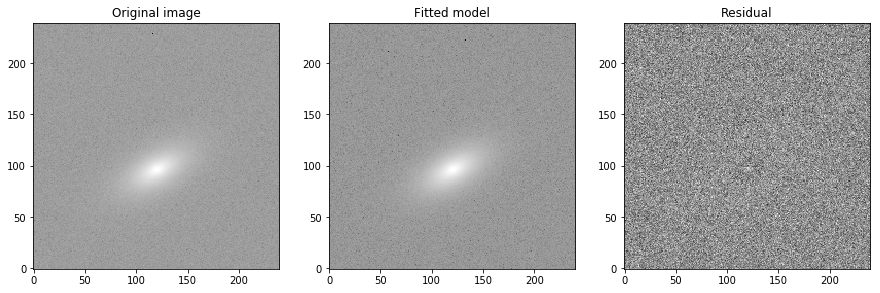

In [14]:
ny, nx = image.shape
y, x = np.mgrid[0:ny, 0:nx] + 0.5
fitted_model = statmorph.ConvolvedSersic2D(
    amplitude=morph.sersic_amplitude,
    r_eff=morph.sersic_rhalf,
    n=morph.sersic_n,
    x_0=morph.sersic_xc,
    y_0=morph.sersic_yc,
    ellip=morph.sersic_ellip,
    theta=morph.sersic_theta)
fitted_model.set_psf(psf)  # always required when using ConvolvedSersic2D
image_model = fitted_model(x, y)
bg_noise = (1.0 / snp) * np.random.standard_normal(size=(ny, nx))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
plt.imshow(log_stretch(normalize(image)), origin='lower', cmap='gray')
ax.set_title('Original image')
ax = fig.add_subplot(132)
ax.imshow(log_stretch(normalize(image_model + bg_noise)), origin='lower', cmap='gray')
ax.set_title('Fitted model')
ax = fig.add_subplot(133)
residual = image - image_model
ax.imshow(normalize(residual), origin='lower', cmap='gray')
ax.set_title('Residual')